### A passing model to find out players who manage to complete harder passes more successfully

#### The xP Index

Here I derived an xP (Expected pass, the probability that the pass is successully completed for each attempt.) Index by using a logistic regression model, which has distance to the keep at pass start location and the difference of distances to the keep between pass start and pass end locations as continuous features. I enriched the model by making use of head pass, high pass and simple pass as categorical (binary) variables. By using this model, I classified good passers by filtering some of the players with respect to certain metrics. Afterwards, I put them on a scatter plot, where x-axis is pass accuracy and y-axis is xP Index, to point out a number of good passer candidates. I used Wyscout’s Premier League data (Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000, Retrieved from: https://figshare.com/collections/Soccer_match_event_dataset/4415000/2) and used a subsample of 50,000 passing events due to computational reasons. Below code shows how I made it step by step. 

#### Essentials first

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import FCPython 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

Let's first load the event data for England and convert it into a dataframe. Then check what the columns are to see how to continue.

In [ ]:
with open('YOUR/PATH/TO/THE/FOLDER/events_England.json') as f:
    data = json.load(f)
    
raw = pd.DataFrame(data)
# Just to check what the columns are
for col in raw.columns: 
    print(col) 

I will eventually evaluate passing actions so I extracted all pass attempts from the dataset (Thanks to the column 'eventName'.) by the below code:

In [ ]:
passes = raw[raw['eventName']=='Pass']
# Due to computational reasons, I have to select a random subsample.
# I set the random_state = 42, in order to make sure that it will take out the same sample for each run.
passes = passes.sample(n = 50000, random_state = 42)
cols = ['Acc_pass', 'X_start', 'Y_start', 'C_start', 
        'X_end', 'Y_end', 'C_end', 'Distance_to_keep_start', 
        'Distance_to_keep_end', 'Distance_pass' ]
pass_model = pd.DataFrame(columns=cols) ## Initially I created an empty dataset. Below code will fill that in.

for i,pass_ in passes.iterrows():
    
    # Pass start location
    pass_model.at[i,'X_start']=100-pass_['positions'][0]['x']
    pass_model.at[i,'Y_start']=pass_['positions'][0]['y']
    pass_model.at[i,'C_start']=abs(pass_['positions'][0]['y']-50)
    
    #Pass end location
    pass_model.at[i,'X_end']=100-pass_['positions'][1]['x']
    pass_model.at[i,'Y_end']=pass_['positions'][1]['y']
    pass_model.at[i,'C_end']=abs(pass_['positions'][1]['y']-50)
    
    #Distances (from the start location of the pass to the keep)
    x_start=pass_model.at[i,'X_start']*105/100
    y_start=pass_model.at[i,'C_start']*65/100
    pass_model.at[i,'Distance_to_keep_start']=np.sqrt(x_start**2 + y_start**2)
    
    #Distances (from the end location of the pass to the keep)
    x_end=pass_model.at[i,'X_end']*105/100
    y_end=pass_model.at[i,'C_end']*65/100
    pass_model.at[i,'Distance_to_keep_end']=np.sqrt(x_end**2 + y_end**2)
    
    #Pass distance
    pass_model.at[i,'Distance_pass'] = np.sqrt(abs(x_start-x_end)**2 + abs(y_start-y_end)**2)
        
    #Accurate passes   
    pass_model.at[i,'Acc_pass']=0
    for passtags in pass_['tags']:
        if passtags['id']==1801:
            pass_model.at[i,'Acc_pass']=1
    sys.stdout.write('.'); sys.stdout.flush(); #Just for visual check while the code is runnung, whether the loop works or not.



Then I added some extra features which may come in handy during the modelling phase. These are the pass type, pass distance and the distance that the pass covered towards the keep on the x-axis. I converted the numeric values into floats later on as I will use a correlation plot to figure out the relevant feature candidates while modelling. 

In [ ]:
# I added to more columns, which may come in handy while modelling. 
pass_model['dX'] = pass_model['X_start'] - pass_model['X_end']
pass_model['d_Distance'] = pass_model['Distance_to_keep_start'] - pass_model['Distance_to_keep_end']

# Turn them into floats as correlations cannot be plotted while all columns are objects.
pass_model = pass_model.astype(float)
# Pass types are added from raw data.
subEventName = passes['subEventName']
pass_model = pass_model.join(subEventName)

The below code is written to build the correlation plot:
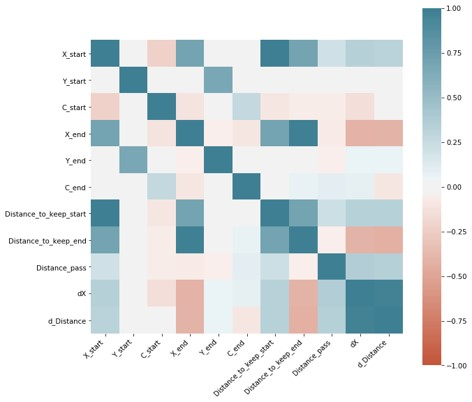

Due to bias variance trade off, we know that models with high number of features are good at capturing all sort of variations in the data, while they usually provide poor results when being tested on another dataset. This model indeed could be reduced to a reasonable number of features, as the correlation heatmap shows that some continuous features are strongly correlated with each other and therefore, there is no need to use all of them. 

In [ ]:
## CORRELATION PLOT ##
# I defined a function to plot the correlation plot for all continuous features.
df_corr = pass_model[['X_start', 'Y_start', 'C_start', 
        'X_end', 'Y_end', 'C_end', 'Distance_to_keep_start', 
        'Distance_to_keep_end', 'Distance_pass', 'dX', 'd_Distance']]

def corrplot(input_df):
    corr = input_df.corr()
    fig, ax = plt.subplots(figsize=(10,10)) 
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

corrplot(df_corr)

I manually created the dummies for pass types (categorical variable) and made the data all set for modelling. 

In [1]:
# Creating dummy variables here.
df_temp = pd.get_dummies(pass_model['subEventName'], prefix_sep='_', drop_first=True)
pass_model = pd.concat([pass_model, df_temp], axis=1)
pass_model = pass_model.drop(columns= ['subEventName'])
pass_model.columns=['Acc_pass', 'X_start', 'Y_start', 'C_start', 'X_end', 'Y_end', 'C_end', 'Distance_to_keep_start', 'Distance_to_keep_end', 'Distance_pass', 'dX', 'd_Distance', 'Hand_pass', 'Head_pass', 'High_pass', 'Launch', 'Simple_pass', 'Smart_pass']

NameError: name 'pd' is not defined

I initiated modelling with a number of experiments. First, a simple one where only the starting point of the pass is taken into consideration. Later on, I tried a number of quadratic models.

Poor results gathered from the models specified in the below code. 

In [2]:
# Building a model on X_start and Y_start
pass_model_xystart = smf.glm(formula="Acc_pass ~ X_start + Y_start" , data=pass_model, 
                           family=sm.families.Binomial()).fit()
print(pass_model_xystart.summary())  

## - I gave a try to a number of quadratic model here.  ## A new dataset is created for this purpose.

pass_model_quad = pass_model[['Acc_pass', 'X_start', 'Y_start', 'Distance_to_keep_start', 'd_Distance', 'Head_pass', 'High_pass', 'Simple_pass']]
pass_model_quad['XY'] = pass_model_quad['X_start'] * pass_model_quad['Y_start']
pass_model_quad['X2'] = pass_model_quad['X_start']**2
pass_model_quad['Y2'] = pass_model_quad['Y_start']**2
pass_model_quad['Distance_to_keep_start2'] = pass_model_quad['Distance_to_keep_start']**2

# I have tried a number of quadratic models here. Below is only the last one that I gave a try. -
pass_model_xy_quad = smf.glm(formula="Acc_pass ~ Distance_to_keep_start2 + d_Distance + Head_pass + High_pass + Simple_pass" , data=pass_model_quad, 
                           family=sm.families.Binomial()).fit()
print(pass_model_xy_quad.summary()) 

NameError: name 'smf' is not defined

#### Conclusion

The ideal model is specified in the below. It has roughly -18.000 log-likelihood, which is much higher than the quadratic model. I ran different models including all possible variables, but none of them leads to a significant increase in the log-likehood. Which is why, I conclude with the simplest one, which is the one in the below. As briefly stated before, simpler model is selected due to bias variance tradeoff. 

In [ ]:
pass_model1 = smf.glm(formula="Acc_pass ~ Distance_to_keep_start + d_Distance + Head_pass + High_pass + Simple_pass" , data=pass_model, 
                           family=sm.families.Binomial()).fit()
print(pass_model1.summary()) 

Below summary table can be printed out with the below code:

#### Summary Table
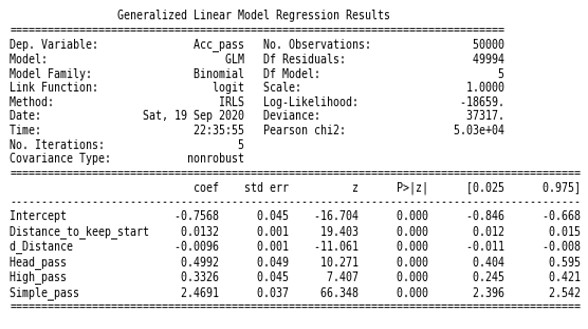

In [ ]:
plt.rc('figure', figsize=(6, 3.5))
plt.text(0.01, 0.05, str(pass_model1.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout() ## To print out the summary table.

I concluded with the above model so I added the probabilities as a column to the main dataframe by the code below:

In [ ]:
pass_model['xP'] = pass_model1.predict(pass_model)

#### A small subsection. Testing the model, whether it is overfitting or not. 

Even though I am pretty sure that the model is just fine due to its generalized nature, I inspected any level of overfitting just in case, by splitting the data into train and test. The code for this process is specified in the below:

In [ ]:
# The dataset is separated into target (Acc_pass) and features. This will be used during classification.
y = pass_model['Acc_pass']
X = pass_model.drop(columns=['Acc_pass'])

# Split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Logistic regression - for classification purposes. To check the accuracy of the model.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

THRESHOLD = 0.80 ## Relying on the average pass accuracy. 
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

Classification accuracy is fair enough. Therefore I conclude this would be a fair model to use to calculate xP, expected pass, in other words.

Now it is time to call player ids and their positions (Such as defender, midfielder etc.) from the main dataframe and append it to our model data. 

In [ ]:
playerId = passes['playerId']
pass_model = pass_model.join(playerId)

# IDs must match with those in players data. 
with open('YOUR/PATH/TO/THE/FOLDER/players.json') as name_file:
    data_id = json.load(name_file)
id_dataframe = pd.DataFrame(data_id)
id_dataframe = id_dataframe[['wyId', 'firstName', 'lastName']]
id_dataframe['Name'] = id_dataframe['firstName'].str.cat(id_dataframe['lastName'],sep=" ")
id_dataframe = id_dataframe.drop(columns = ['firstName', 'lastName'])
id_dataframe.columns=['playerId', 'Name']

df_final = pass_model.merge(id_dataframe, how='left', left_on='playerId', right_on='playerId')

## Position names are added to the main dataset as well. 
position_dataframe = pd.DataFrame(data_id)
position_dataframe['role_name'] = position_dataframe.role.apply(lambda x: x.get('name'))

position_dataframe = position_dataframe[['wyId', 'role_name']]
position_dataframe.columns=['playerId', 'role_name']

df_final = df_final.merge(position_dataframe, how='left', left_on='playerId', right_on='playerId')

Now I would like to explain how the xP Index is derived and how it can be used to scout "Elite" passers.

#### How xP Index is derived & How it works

After model building, I named the probabilities calculated for each observation as xP (The code already given above), and derived the xP index for each player simply by the sum of the accurate passes of the given player divided by the sum of xP of the same player, and multiplying it by 100. Then we can simply interpret that players who have an xP Index of higher than 100 exceeds the expectations (Completes more successful passes than the model estimates.). 

I filtered the outcome only for midfielders and put it onto a scatter plot where x-axis is the pass accuracy (mean accurate pass) and y-axis is the xP Index. Not surprisingly, they are highly correlated (the graph is in the below.) but I conclude that it has enough variation to derive some interesting analysis out of it. The code for the above-mentioned process (How to filter out midfielders) can be seen in the below. The code also covers how I filtered out the so-called "Elite" ones among them (with a pass accuracy of higher than 85% and an xP Index of higher than 100, among those who made at least 200 successful passes within the sample.). Those will be used in the final analysis.

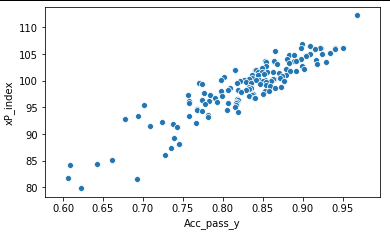

In [ ]:
## - Midfielders to be filtered out here - ##
df_midfielders = df_final[df_final['role_name']=='Midfielder']
df_xP = df_midfielders.groupby('Name')['xP', 'Acc_pass'].sum()
df_xP['xP_index'] = (df_xP['Acc_pass'] / df_xP['xP']) * 100
df_xP = df_xP[df_xP['Acc_pass'] >= 30]
df_xP = df_xP.sort_values(by ='xP_index', ascending=False)
df_average_acc = df_midfielders.groupby('Name')['Acc_pass'].mean()
df_xP = df_xP.merge(df_average_acc, how='left', left_on='Name', right_on='Name')

# I just added an extra filter to see so-called "Elite" passers (Among midfielders.)
df_final_analysis_elite = df_xP[['Acc_pass_x', 'xP_index', 'Acc_pass_y']]
df_final_analysis_elite = df_final_analysis_elite[df_final_analysis_elite['xP_index'] > 100]
df_final_analysis_elite = df_final_analysis_elite[df_final_analysis_elite['Acc_pass_y'] > 0.85]
df_final_analysis_elite = df_final_analysis_elite[df_final_analysis_elite['Acc_pass_x'] > 200]

# Some scouting after elite players are listed. Measures are relaxed a bit to see the potential elites. 
df_final_analysis = df_xP[['xP_index', 'Acc_pass_y']]

sns.scatterplot(data=df_final_analysis, x="Acc_pass_y", y="xP_index")

I focused on the top right corner of the above graph, where I believe the elite passers are at. To that end, as I specified before as "Elite" ones, I took only players who has higher than 200 accurate passes (within the subsample of 50,000), pass accuracy of higher than 85% and xP Index of higher than 100 into account and I ended up with a list of 15 midfielders. These players are: Fernandinho, Fabian Delph, Granit Xhaka, Ilkay Gundogan, Nemanja Matic, Jordan Henderson, David Silva, Paul Pogba, N’Golo Kante, Mesut Ozil, Christian Eriksen, Moussa Dembele, Dale Stephens, Eric Dier and Idrissa Gueye. Oriol Romeu is listed out as it could not exceed 100 xP Index threshold, even though the player achieved quite high pass accuracy. Afterwards, I decided to relax the restrictions and refiltered the players without a minimum number of successful passes, to see the players who had not reached enough number of successful pass, but possess a potential to be a very good passer in the Premier League. The code how to find out those players and the scatter plot that contains them can be seen in the below:
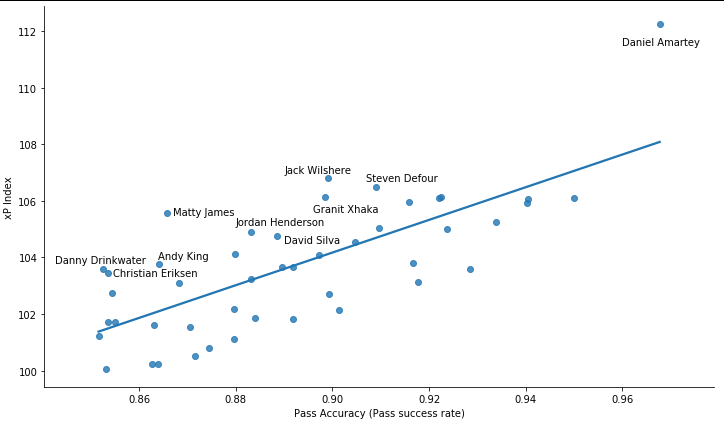

In [ ]:
df_final_analysis2 = df_final_analysis[df_final_analysis['xP_index'] > 100]
df_final_analysis2 = df_final_analysis2[df_final_analysis2['Acc_pass_y'] > 0.85]
df_final_analysis2 = df_final_analysis2.sort_values(by ='xP_index', ascending = False)

## Scatter plot to point out some potentials.
figs, axes = plt.subplots(figsize=(12, 7))
axes = sns.regplot(data=df_final_analysis2, x="Acc_pass_y", y="xP_index", ci=None)
plt.text(0.96,111.5,'Daniel Amartey')
plt.text(0.89,107,'Jack Wilshere')
plt.text(0.907,106.7,'Steven Defour')
plt.text(0.896,105.6,'Granit Xhaka')
plt.text(0.867,105.5,'Matty James')
plt.text(0.88,105.15,'Jordan Henderson')
plt.text(0.89,104.5,'David Silva')
plt.text(0.864,103.96,'Andy King')
plt.text(0.8425,103.8,'Danny Drinkwater')
plt.text(0.8545,103.35,'Christian Eriksen')
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('Pass Accuracy (Pass success rate)')
plt.ylabel('xP Index')

#### Conclusions

I focused on the players being located noticeably above the regression line, as these are the players having much higher-than-estimated xP Index with respect to their pass accuracies. In other words, these players tend to complete harder pass attempts successfully, as they managed to score a high xP Index than a simple regression model would estimate. I intentionally put the names of three world class midfielders, Wilshere, Henderson and David Silva, to make them as a benchmark to the rest (Wilshere is obviously a great passer.). According to my findings, Steven Defour, Granit Xhaka, Matty James, Andy King, Danny Drinkwater and Christian Eriksen are effective passers, as I conclude they tend to complete passes in tougher situations as they achieved to reach a high xP Index with respect to their pass accuracies. Some of them are potentially out of the range of the scouting departments of several clubs due to their relatively low reputation compared to globally known passing expert midfielders. Which is why, I conclude that if I were to report effective passers who are underdogs at the same time, along with the representation of the model and xP Index, I would give some these players’ names, such as Matty James, Andy King and Steven Defour, to the chief scout of team (Daniel Amartey constitutes an exception as it is in the list by covering only 30 accurate passes. I would continue to follow his development before reporting his name to the chief scout.). 

#### Final remarks

I believe this will make a sincere contribution to the attempts of quantifying player performances in football. More complex prediction models can be built, such as by making use of gradient boosting or bagging methods, but that would cannibalize interpretability due to their black-box nature. Here, I intentionally use a generalized linear model for interpretation purposes as in real life, football coaches are not data experts and therefore tend to know the underlying reasons behind the player performance, for whatever attribute we are looking for. For the same reason, I tried to derive a very easy-to-comprehend metric, which is the xP Index. Further development can be made on the xP Index, such as recalculating the index by weighing the pass attempts with respect to its probability. On the other hand, the logistic model does not take into account whether the pass action occurs under pressure or not and the number of opponent players close to the pass location, between the keep and pass location etc. Which is why, I can conclude without hesitation that there is a lot of room for improvement in this model. Anyhow, it provides a fair generalization in terms of how to identify effective passers among all other players having high pass accuracy rate. 